In [1]:
#Uncomment following lines if running in Google Colab 
! pip install -q 'gwosc==0.5.4'
! pip install -q 'gwpy==2.0.2'
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf -P data/
! pip install -q 'PyCBC==1.18.0' 'lalsuite==6.82'

Reason for being yanked: Metadata is broken
     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 51 kB 5.1 MB/s 
     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 3.6 MB 35.6 MB/s 
--2022-02-15 01:01:12--  https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4025842 (3.8M)
Saving to: ‘data/challenge2.gwf’

challenge2.gwf      100%[===================>]   3.84M  1.55MB/s    in 2.5s    

2022-02-15 01:01:15 (1.55 MB/s) - ‘data/challenge2.gwf’ saved [4025842/4025842]

     |████████████████████████████████| 6.3 MB 4.5 MB/s 
     |████████████████████████████████| 27.3 MB 57.9 MB/s 
     |████████████████████████████████| 1.4 MB 50.4 MB/s 
  Installing build depen

In [2]:
#imports
import gwosc
import gwpy
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
%matplotlib inline
from pycbc.waveform import get_td_waveform
from pycbc import frame
import pylab
import numpy
from pycbc.filter import highpass, matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

In [3]:
#import data and check sample rate and duration
data = TimeSeries.read('data/challenge2.gwf',channel = 'H1:CHALLENGE2')
print("The data has the following properties,\n sample rate: {} \n duration: {}".format(data.sample_rate,data.duration))
#save epoch for later
epoch = data.epoch

The data has the following properties,
 sample rate: 4096.0 Hz 
 duration: 128.0 s


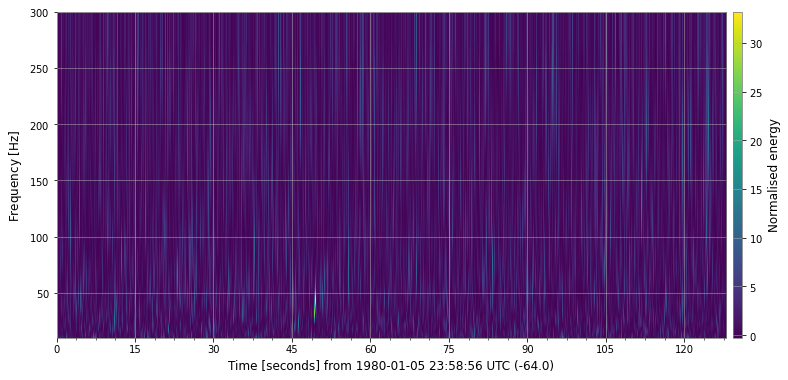

In [4]:
#perform q transform to try and find time of merger
q = data.q_transform(frange=(10, 300))
plotq = q.plot()
plotq.colorbar(label="Normalised energy")

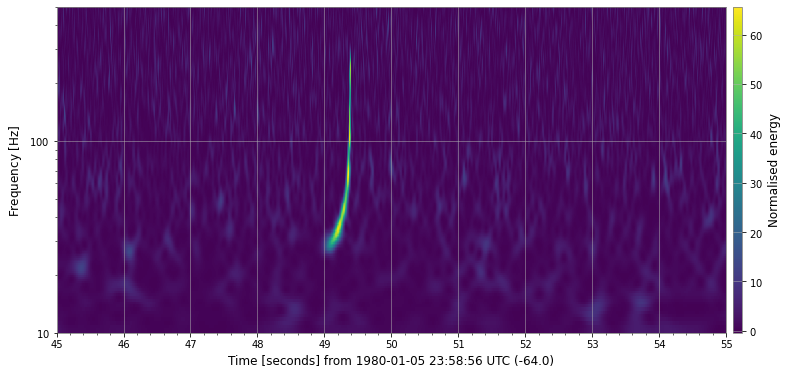

In [5]:
#take a smaller time-range to see the event better
q = data.q_transform(frange=(10, 500), qrange=(10, 400), outseg=(-19,-9)) 
plotq = q.plot()
axisq = plotq.gca()
axisq.set_yscale('log')
axisq.set_epoch(epoch)
axisq.colorbar(label="Normalised energy")

In [6]:
#the merger seems to start at 49s and the duration is approximatly 0.5s
#the merger also does not seem to include any frequency lower than 20Hz


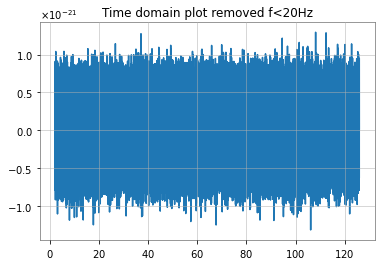

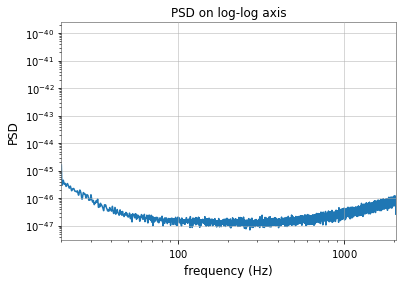

In [7]:
#in order to use this wave function to extract the signal we first need to estimate the PSD

#it is easier to have the data imported by pycbc
data = frame.read_frame('data/challenge2.gwf', 'H1:CHALLENGE2')
sample_rate = data.sample_rate
#Let the time start at 0s instead of -64s
data.start_time = 0

#removing frequencies lower than 20Hz
#remove first and last 2 seconds to prevent time coruption due to highpassing
data = highpass(data,20)
data = data.crop(2,2)
pylab.figure()
pylab.plot(data.sample_times,data)
pylab.title('Time domain plot removed f<20Hz')


# 4 second samples are chosen for the PSD as the total duration of the data is 124s and this is nicely divisible by 4
sample_length = 4
PSD = data.psd(sample_length)
#interpolating the PSD to match our data
PSD = interpolate(PSD,data.delta_f)

#1/PSD will act as the filter, we need to keep in mind that the data has been highpassed above 20Hz
PSD = inverse_spectrum_truncation(PSD,int(sample_length * sample_rate),low_frequency_cutoff=20)

#plot the PSD on log-log axis up to the nyquist frequency (sample_rate/2)
pylab.figure()
pylab.plot(PSD.sample_frequencies,PSD)
pylab.xlim(20,sample_rate/2)
pylab.xscale('log')
pylab.yscale('log')
pylab.xlabel('frequency (Hz)')
pylab.ylabel('PSD')
pylab.title('PSD on log-log axis')
pylab.show()


In [8]:
#now making a template wave function using the info that is given
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=data.delta_t,
                         spin = 0,
                         f_lower=20)
#resize to match the size of the data
hp.resize(len(data))
hc.resize(len(data))

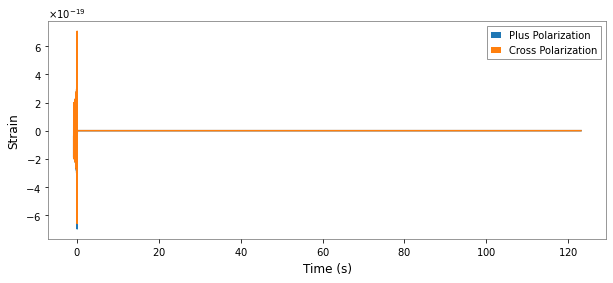

In [9]:
#plot the wave function
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()


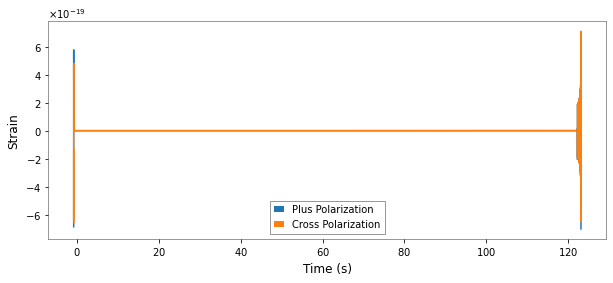

In [10]:
#in order to make the SNR time series to match the merger we need to shift the wave functions so that the merger in the wave functions occurs in the first data bin
hp_shifted = hp.cyclic_time_shift(hp.start_time)
hc_shifted = hc.cyclic_time_shift(hc.start_time)
#plot the shifted wave function
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp_shifted, label='Plus Polarization')
pylab.plot(hp.sample_times, hc_shifted, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()
#as is visible from the plot, the merger occurs roughly at the first data bin

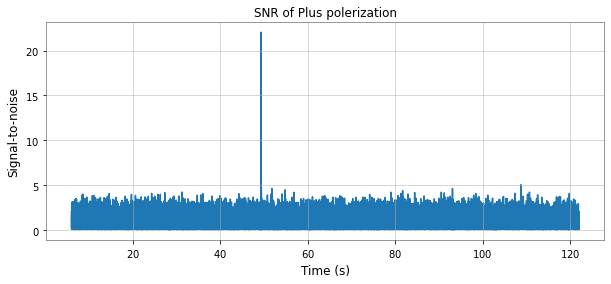

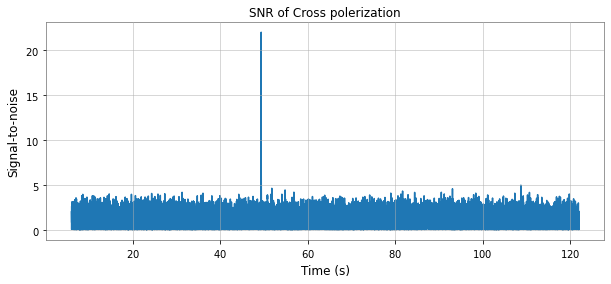

Plus polerization: Signal found at 49.3671875s with SNR 22.038166990902532
Cross polerization: Signal found at 49.3671875s with SNR 22.021293142349837


In [11]:
#compute the SNR by using matched_filter
snr_p = matched_filter(hp_shifted, data, psd=PSD, low_frequency_cutoff=20)
snr_c = matched_filter(hc_shifted,data, psd=PSD, low_frequency_cutoff=20)

#remove time corruption due to filtering
snr_p = snr_p.crop(4,4)
snr_c = snr_c.crop(4,4)

#plot the SNR for both the plus and cross polerization
pylab.figure(figsize=[10, 4])
pylab.plot(snr_p.sample_times, abs(snr_p))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.title('SNR of Plus polerization')
pylab.show()

pylab.figure(figsize=[10,4])
pylab.plot(snr_c.sample_times,abs(snr_c))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.title('SNR of Cross polerization')
pylab.show()

#extract the height and time of the peak in SNR (as there is a high signal to noise ratio there, so there is likely a signal there)
peak = abs(snr_p).numpy().argmax()
snrp = snr_p[peak]
time = snr_p.sample_times[peak]
print("Plus polerization: Signal found at {}s with SNR {}".format(time, abs(snrp)))
peak2 = abs(snr_c).numpy().argmax()
snrp2 = snr_c[peak2]
time2 = snr_c.sample_times[peak2]
print("Cross polerization: Signal found at {}s with SNR {}".format(time2, abs(snrp2)))

In [13]:
# the matched filter SNR and time of the plus and cross polerization match
# and the SNR of the signal is 22